In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from pmdarima import ARIMA
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

The data is in an xlsx file

The file contains information on drought levels, organized by city and state, reported since January 2003 and recorded biweekly

In [2]:
file_name = "sequia2023.xlsx"
sheet_name = 0
df = pd.read_excel(file_name, sheet_name=sheet_name)

In [3]:
df.head()

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,1002,1,2,Asientos,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,1003,1,3,Calvillo,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,1004,1,4,Cosío,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,1005,1,5,Jesús María,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Data preparation 

We will remove the unnecessary columns, as the majority of them are identification keys.

We will also remove the cities from each state, as our focus will be uniquely on states. We only need to know the state and the historical data of the droughts.

In [4]:
df = df.drop(columns=["CVE_CONCATENADA","CVE_ENT","CVE_MUN","NOMBRE_MUN", "ORG_CUENCA", "CLV_OC","CVE_CONC","CON_CUENCA","CVE_CONC"])

In [5]:
df.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Replacing the drought levels with numerical values as follows:

1. Minimum (10% water reduction) D0 = 1

2. Moderate (15%) D1= 2
   
3. Moderate (25%) D2= 3

4. Severe (40%) D3= 4

5. Critical (>40%) D4= 5

In [6]:
df_replace = df.replace({'D0': 1,'D1':2,'D2':3,'D3':4,'D4':5})

#### Missing values:
All NA values do not indicate missing data; rather, they signify that no drought was reported on those days. Therefore, we will replace them with 0.

In [7]:
df_replace=df_replace.fillna(0)

In [8]:
df_replace.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0
1,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0
2,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
4,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0


The 'Entidad' column contains the states of the country, repeated because the database is divided into cities. However, our objective is to determine the drought level by state. Therefore, the maximum value will be taken, meaning the highest drought level among all the cities belonging to a specific state will be assigned to the state. This approach is preferred because if there is a possibility that one city within the state has a high drought level, it is more prudent to consider the most critical situation rather than the average, for example.

In [9]:
df_replace["ENTIDAD"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro de Arteaga', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán',
       'Zacatecas'], dtype=object)

In [10]:
new_df = df_replace.groupby('ENTIDAD').max()
new_df.head()

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2023-08-15,2023-08-31,2023-09-15,2023-09-30,2023-10-15,2023-10-31,2023-11-15,2023-11-30,2023-12-15,2023-12-31
ENTIDAD,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
Baja California,4.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baja California Sur,3.0,3.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Campeche,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Chiapas,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


We will create a new dataframe containing the maximum values and transpose it, so that each state is represented in a separate column.

In [11]:
df_trans = new_df.T 
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31 00:00:00,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28 00:00:00,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [12]:
df_trans.index = pd.to_datetime(df_trans.index)

In [13]:
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [14]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2003-01-31 to 2023-12-31
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Aguascalientes                   370 non-null    float64
 1   Baja California                  370 non-null    float64
 2   Baja California Sur              370 non-null    float64
 3   Campeche                         370 non-null    float64
 4   Chiapas                          370 non-null    float64
 5   Chihuahua                        370 non-null    float64
 6   Ciudad de México                 370 non-null    float64
 7   Coahuila de Zaragoza             370 non-null    float64
 8   Colima                           370 non-null    float64
 9   Durango                          370 non-null    float64
 10  Estado de México                 370 non-null    float64
 11  Guanajuato                       370 non-null    float64
 12  Gue

In [15]:
df_trans = df_trans.astype(int)

In [16]:
df_trans.describe()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.854054,2.321622,1.159459,1.332432,1.829730,2.548649,0.802703,2.437838,0.981081,2.045946,...,1.167568,1.945946,2.000000,2.835135,1.389189,2.383784,0.810811,2.121622,1.297297,1.597297
std,1.223216,1.380003,1.191196,1.074603,1.249686,1.359125,0.840372,1.555714,1.047474,1.355726,...,0.987196,1.254714,1.333333,1.188179,1.287796,1.428990,0.853427,1.147080,1.078614,1.320053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.250000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,2.000000,...,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,2.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,...,2.000000,3.000000,3.000000,4.000000,2.000000,4.000000,1.000000,3.000000,2.000000,3.000000
max,5.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,...,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000


We observe that nearly all states exhibit maximum values of 5, which is the highest level of drought.

In [17]:
high= df_trans.describe().loc['mean'] >= 2
results = df_trans.describe().loc[:, high]
print(results)

ENTIDAD  Baja California   Chihuahua  Coahuila de Zaragoza     Durango  \
count         370.000000  370.000000            370.000000  370.000000   
mean            2.321622    2.548649              2.437838    2.045946   
std             1.380003    1.359125              1.555714    1.355726   
min             0.000000    0.000000              0.000000    0.000000   
25%             1.000000    1.250000              1.000000    1.000000   
50%             2.000000    2.000000              3.000000    2.000000   
75%             4.000000    3.000000              4.000000    3.000000   
max             5.000000    5.000000              5.000000    5.000000   

ENTIDAD     Jalisco  Michoacán de Ocampo      Oaxaca     Sinaloa      Sonora  \
count    370.000000           370.000000  370.000000  370.000000  370.000000   
mean       2.016216             2.094595    2.227027    2.000000    2.835135   
std        1.161607             1.163689    1.224114    1.333333    1.188179   
min        0.

In [18]:
df_trans.mean().mean()

1.7191722972972974

The country's average is 1.79, which means that the country suffers from many droughts, a good average would be a value close to 0.

For this project we will randomly select 3 states, one from each region of Mexico: Colima, Morelos, Quintana Roo and Sonora to apply the model

In [19]:
df_new2  = df_trans.loc[:, ['Colima', 'Morelos','Quintana Roo','Sonora']]
df_new2.head()

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora
2003-01-31,0,3,0,5
2003-02-28,0,3,0,5
2003-03-31,0,3,0,5
2003-04-30,0,3,0,5
2003-05-31,0,3,0,5


Once our data is prepared, we will plot the drought levels for all states to observe their behavior since 2003.

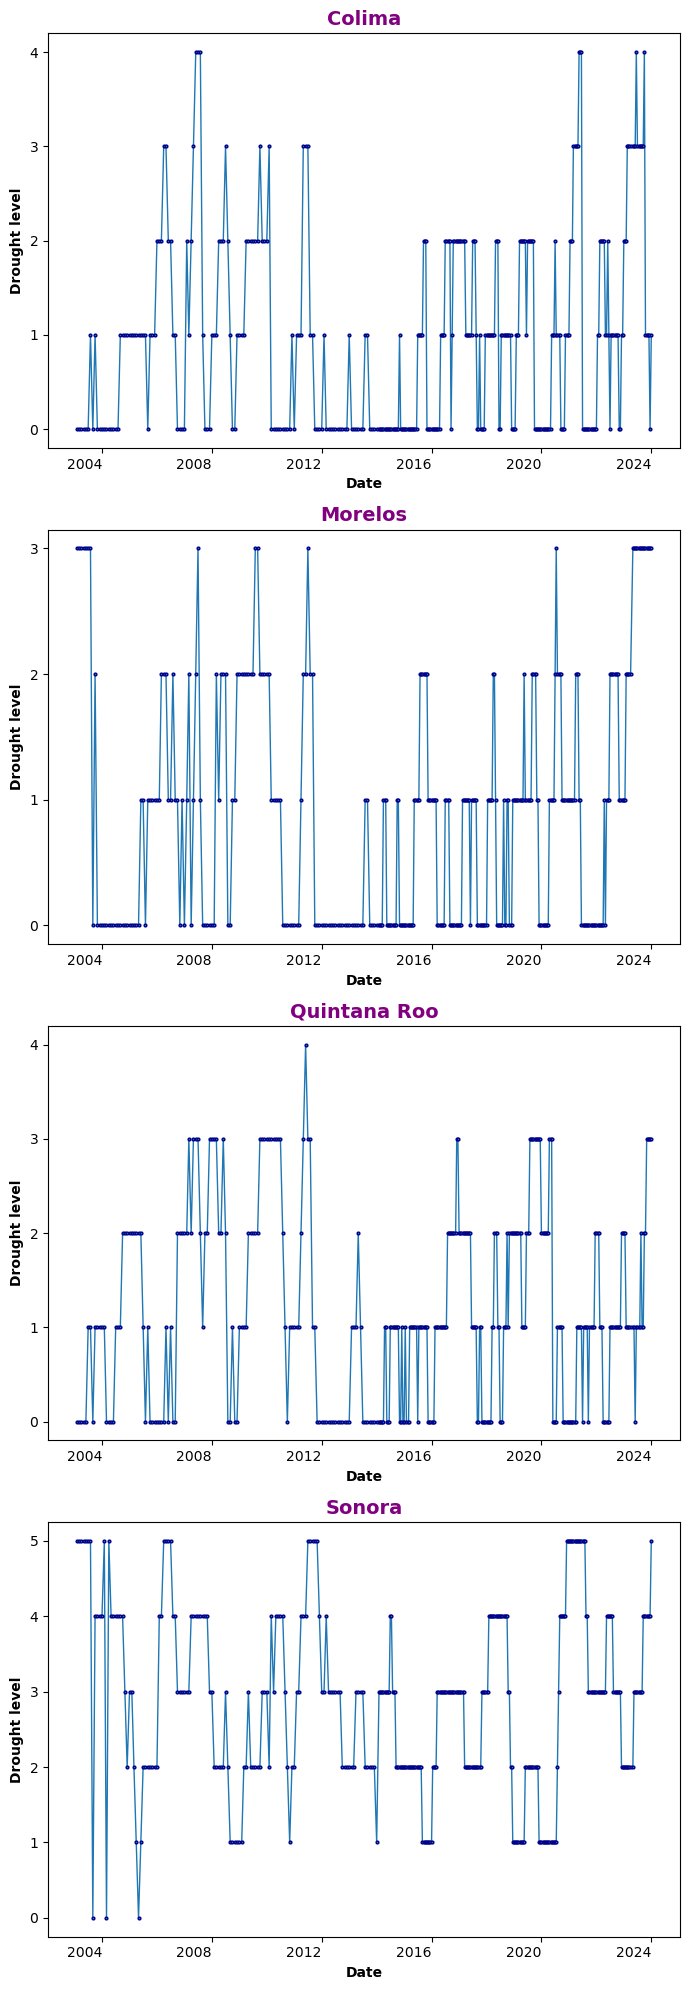

In [20]:
fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
#axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    df_new2[col].plot(ax=axes[i],marker='o',markersize=2,markeredgecolor='darkblue',linewidth=1)
    axes[i].set_ylabel('Drought level',fontweight='bold')  
    axes[i].set_xlabel('Date',fontweight='bold')
    axes[i].set_title(col,fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'purple'})
    axes[i].xaxis.set_tick_params(rotation=0)  
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)
    
plt.tight_layout()

plt.show()

To observe the recent trends over the past 2 years, we will graph the last 49 records

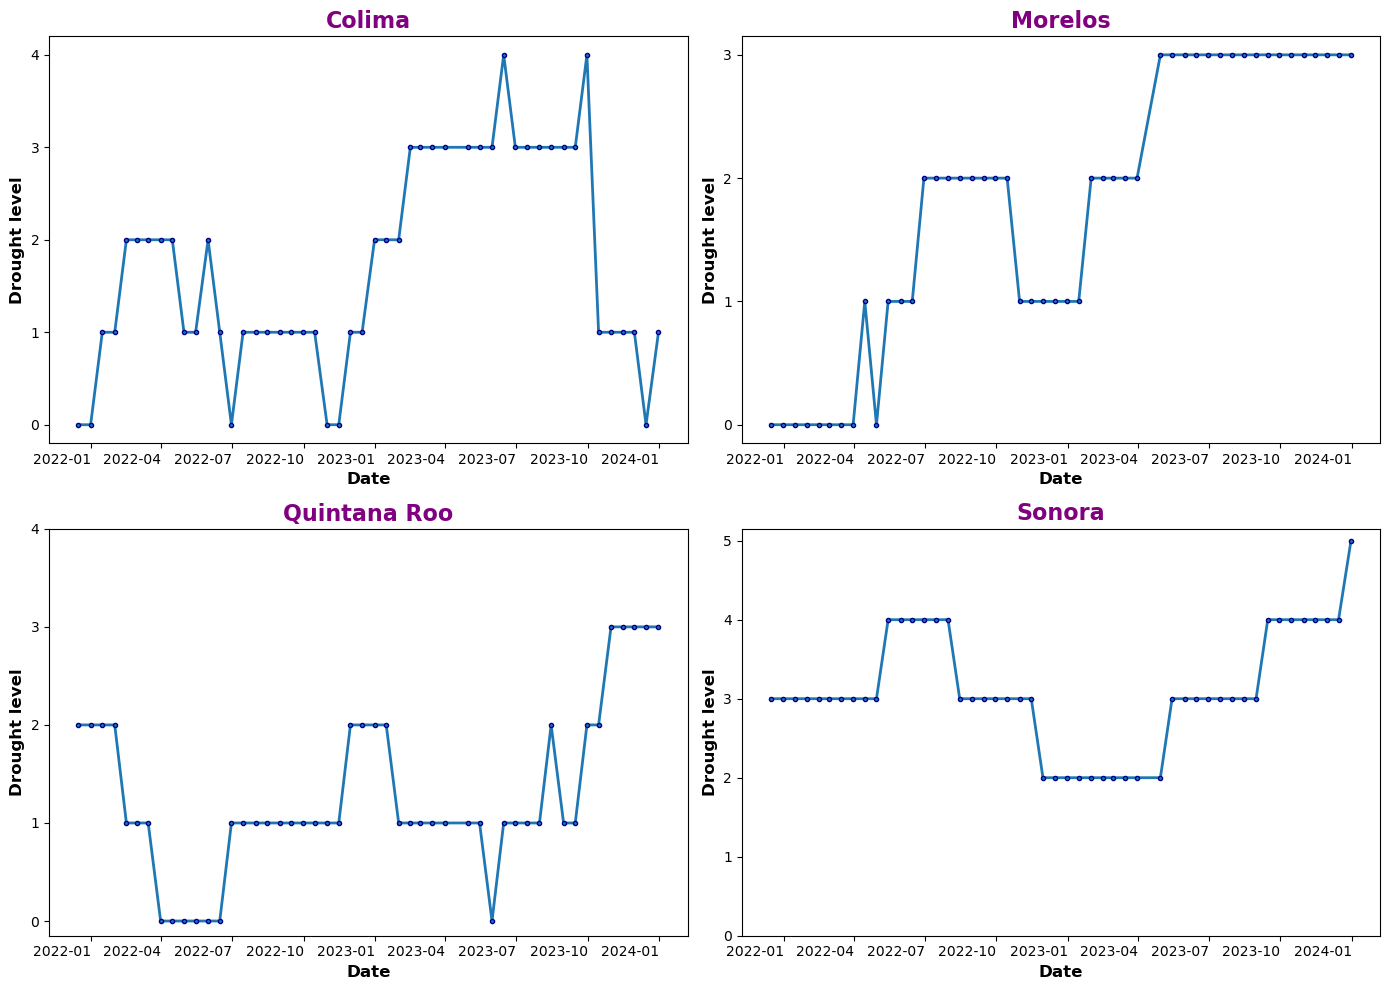

In [21]:
ultimas_20_filas = df_new2.tail(49)

#fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    ultimas_20_filas[col].plot(ax=axes[i],marker='o',markersize=3,markeredgecolor='darkblue',linewidth=2)
    axes[i].set_ylabel('Drought level',fontweight='bold',fontsize=12)  
    axes[i].set_xlabel('Date',fontweight='bold',fontsize=12)
    axes[i].set_title(col,fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'}) 
    axes[i].xaxis.set_tick_params(rotation=0)  
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)

plt.tight_layout()

plt.show()

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as plticker

In [23]:
orig_df = df_new2.copy()

We have our data prepared to apply the model for forecasting. For this project, we will utilize $ARIMA$, as it is a statistical forecasting model.
In the model, the parameters p,d y q, are utilized, each representing a component:

* p for the autoregressive element
* d number of differencing that have been performed
* q for the moving average element

It is not necessary to use all three components, we can have combinations where one or two components are 0, meaning they are not utilized.

The next step in the process will be to determine these parameters for the series.

####  Stationarity (I)
We need our data to be stationary to ensure that the forecasts are more reliable. 

Therefore, we will conduct two tests for each column: the KPSS Test and the ADF Test. Both tests will compare the p-value against the alpha level (0.05) to determine whether the data series is stationary or not.

If:

p-value < $\alpha$ (0.05)

Kpss test = the series is non-stationary and thus needs to be differenced.

ADF test = the series is stationary.

If the ADF indicates stationarity and the KPSS indicates non-stationarity, we might be in a situation of "difference stationarity." This means we need to apply differencing to make the series stationary.

The purpose of differencing is to make the time series stationary.

We need to difference the series until it becomes stationary, but always seeking the minimum differencing; otherwise, the series could be over-differenced which it will affect the model parameters.



State: Colima

Test stationarity for original series
-------------------------------------
ADF Statistic: -6.275331300942066, p-value: 3.9132682689371444e-08
KPSS Statistic: 0.40689098573146765, p-value: 0.07418491994333291

It is stationary.


State: Morelos

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.764518432312849, p-value: 5.57264209836272e-07
KPSS Statistic: 0.36326018373134933, p-value: 0.0929913001157977

It is stationary.


State: Quintana Roo

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.568303932006249, p-value: 1.4872655196526566e-06
KPSS Statistic: 0.0879526229891651, p-value: 0.1

It is stationary.


State: Sonora

Test stationarity for original series
-------------------------------------


C:\Users\dnisg\AppData\Local\Temp\ipykernel_19180\3535644792.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_19180\3535644792.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_19180\3535644792.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_19180\3535644792.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-val

ADF Statistic: -4.210217970334595, p-value: 0.0006331442594822575
KPSS Statistic: 0.14082318829010243, p-value: 0.1

It is stationary.


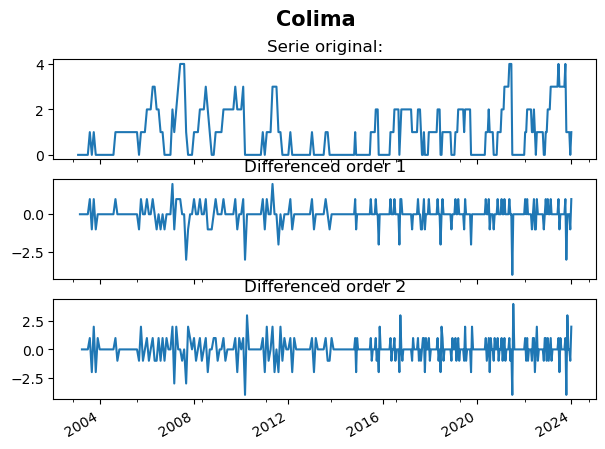

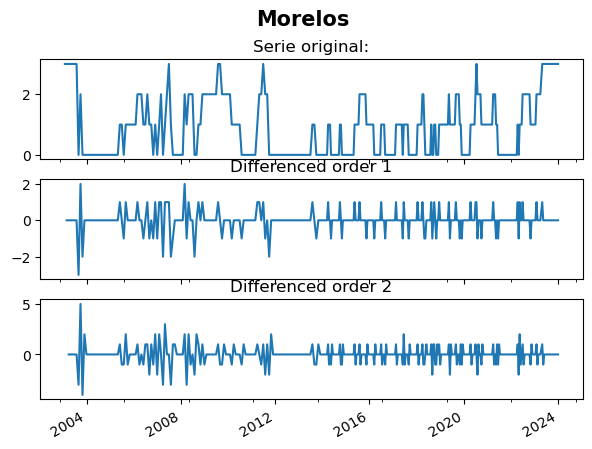

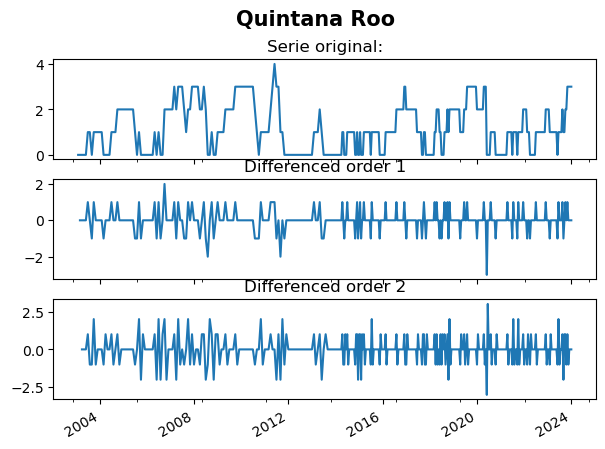

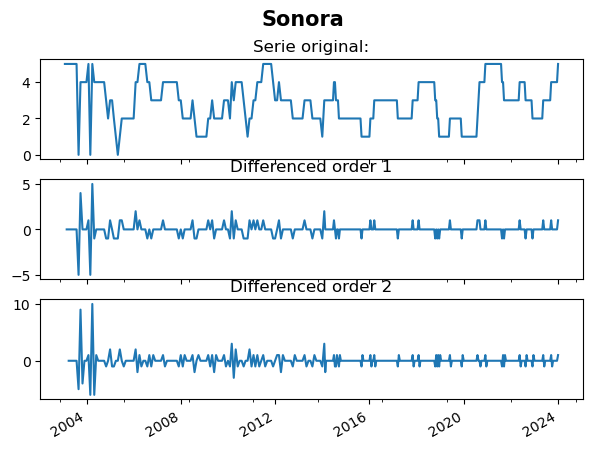

In [24]:
warnings.filterwarnings("default")
datos_diff_1 = {}
datos_diff_2 = {}
value_d= []
for i, col in enumerate(df_new2.columns):
    datos_diff_1[col] = df_new2[col].diff().dropna()
    datos_diff_2[col] = datos_diff_1[col].diff().dropna()
    print('\n')
    print("State:",df_new2.columns[i])
    print('\nTest stationarity for original series')
    print('-------------------------------------')
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
   
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    
    if kpss_result[1] < 0.05 or adfuller_result[1] >0.05:
            
     print('\nTest stationarity for differenced series (order=1)')
     print('--------------------------------------------------')
     adfuller_result1 = adfuller(datos_diff_1[col])
     kpss_result = kpss(df_new2[col].diff().dropna())
     print(f'ADF Statistic: {adfuller_result1[0]}, p-value: {adfuller_result1[1]}')
     print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
             
     if kpss_result[1] < 0.05 or adfuller_result1[1] >0.05:
            print('\nTest stationarity for differenced series (order=2)')
            print('--------------------------------------------------')
            adfuller_result2 = adfuller(datos_diff_2[col])
            kpss_result = kpss(df_new2[col].diff().diff().dropna())
            print(f'ADF Statistic: {adfuller_result2[0]}, p-value: {adfuller_result2[1]}')
            print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
         
            #df_new2[col]=datos_diff_2[col]
            print("The serie is differenced (order 2)")
            d=2
            value_d.append(d)
     else:
        #df_new2[col]=datos_diff_1[col]
        print("\n\nThe serie is differenced (order 1)")
        d=1
        value_d.append(d)
    else:
        print("\nIt is stationary.")
        d=0
        value_d.append(d)
        
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
    fig.suptitle(df_new2.columns[i],fontweight='bold',fontsize=15)
    orig_df[col].plot(ax=axs[0], title='\nSerie original:')
    datos_diff_1[col].plot(ax=axs[1], title='\nDifferenced order 1')
    datos_diff_2[col].plot(ax=axs[2], title='\nDifferenced order 2')

            

As we saw, if the series is stationary, it is not differenced and d=0

If the series is non-stationary, it is differenced twice, but we will take the first differencing if it passes both tests for stationarity, making d=1. If it needs another differencing, d=2. 

The d values for each feature will be stored in value_d, we will use this value for the model we are going to employ.

In [25]:
value_d

[0, 0, 0, 0]

#### Autocorrelation Function (ACF) for MA

After having all our series stationary, we will plot the ACF to identify the value of q

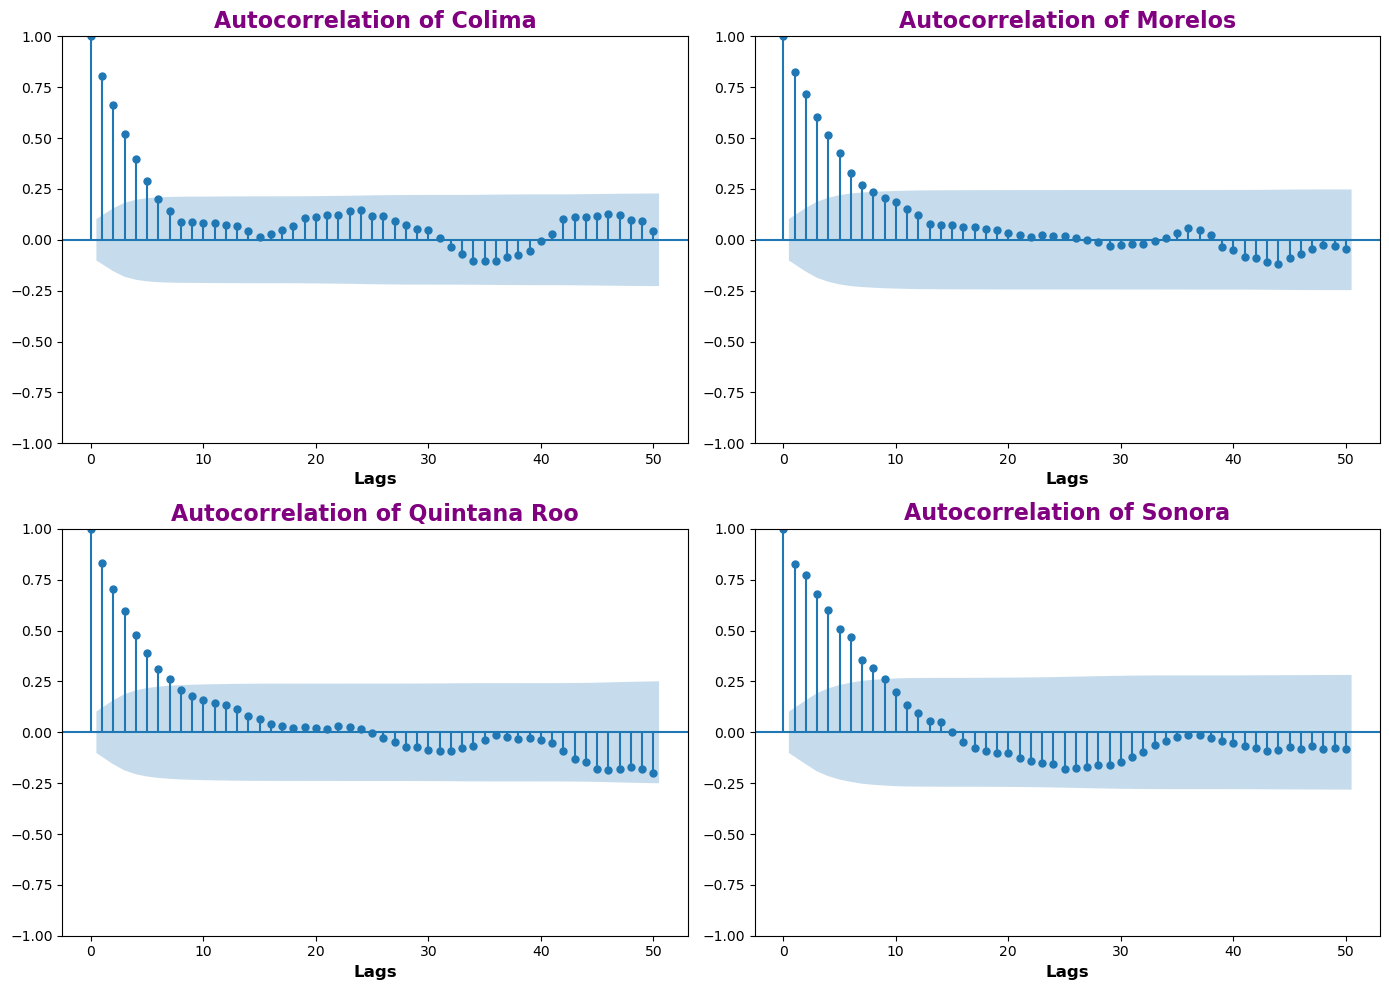

In [26]:
num_cols = len(df_new2.columns)
df_new2=df_new2.fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(df_new2.columns):
    plot_acf(df_new2[col], ax=axes[i], lags=50)
    axes[i].set_title(f'Autocorrelation of {col}',fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'})   
    axes[i].set_xlabel('Lags',fontweight='bold',fontsize=12)

plt.tight_layout()
plt.show()

The ACF calculates the correlation between a time series and its lagged values. The lag at which the ACF falls provides an estimate of the value of q. 

We will assign q for each series conservatively.

In [27]:
value_q=[2,1,2,2]

#### Partial Autocorrelation Function (PACF) for AR
The PACF helps identify the value of p

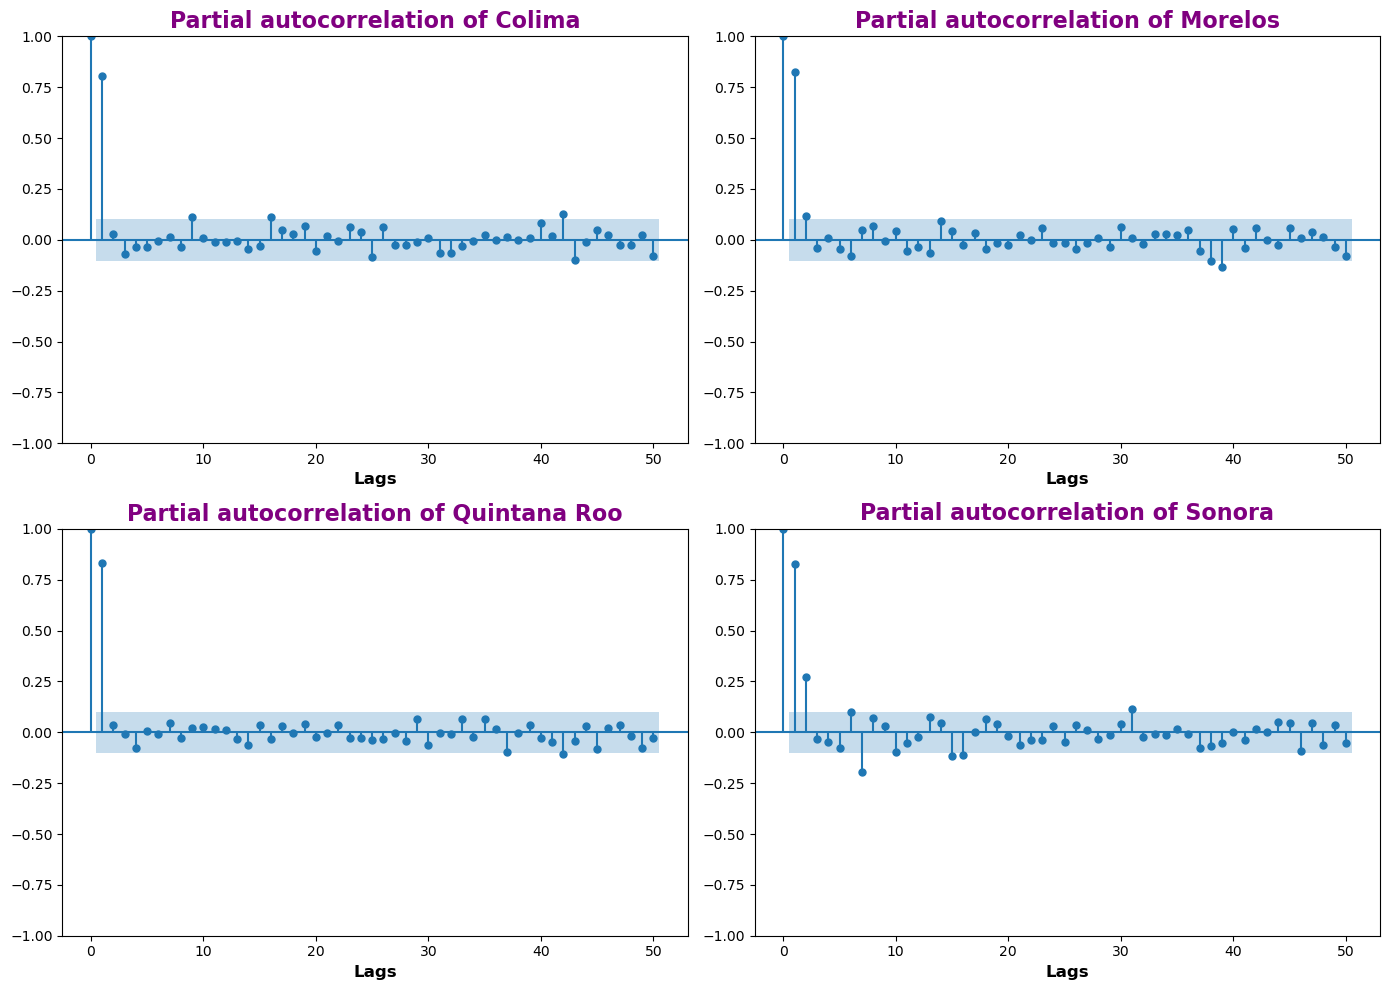

In [28]:
#fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(7, 5*num_cols))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    plot_pacf(df_new2[col], ax=axes[i],lags=50)
    axes[i].set_title(f'Partial autocorrelation of {col}',fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'}) 
    axes[i].set_xlabel('Lags',fontweight='bold',fontsize=12)

plt.tight_layout()
plt.show()

The PACF measures the correlation between a lagged value and the current value of the time series, taking into account the effect of intermediate lags. The lag at which the PACF cuts off provides an indication of the value of p

In [29]:
value_p=[2,2,2,3] 

In [30]:
names=df_new2.columns
valuesmodel = pd.DataFrame()

In [31]:
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_d])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_q])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_p])], ignore_index=True)

Creating a new dataframe to store the model parameters for each feature

In [32]:
valuesmodel.columns=names
new_index=['d', 'q', 'p']
valuesmodel = valuesmodel.set_index(pd.Index(new_index))
valuesmodel

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora
d,0,0,0,0
q,2,1,2,2
p,2,2,2,3


In [33]:
from statsmodels.tsa.arima.model import ARIMA

### SONORA (Northern Region)

In [34]:
print(valuesmodel["Sonora"])

d    0
q    2
p    3
Name: Sonora, dtype: int64


We will utilize ARIMA with the values obtained from the analyses above

In [35]:
arima = ARIMA(df_new2["Sonora"].tolist(), order = (3, 0, 2))

arima_fit = arima.fit()

arima_fit.summary()

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  370
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -348.947
Date:                Fri, 01 Nov 2024   AIC                            711.895
Time:                        00:00:53   BIC                            739.289
Sample:                             0   HQIC                           722.776
                                - 370                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9179      0.269     10.862      0.000       2.391       3.444
ar.L1          0.3772      0.101      3.747      0.000       0.180       0.575
ar.L2         -0.2458      0.076     -3.248      0.001      -0.394      -0.097
ar.L3          0.6036      0.077      7.875      0.000       0.453       0.754
ma.L1          0.2893      0.096      3.004      0.003       0.101       0.478
ma.L2          0.7427      0.063     11.785      0.000       0.619       0.866
sigma2         0.3843      0.018     20.941      0.000       0.348       0.420
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):              3258.72
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ya obtuvimos un AIC de 711.895 pero vamos a probar con otras combinaciones para encontrar el score mas pequeno

In [42]:
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

In [37]:
aicVal=[]
for d in range(0,4):
    for ari in range(0, 4):
        for maj in range(0,4):
            try:
                arima_obj = ARIMA(df_new2["Sonora"].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[[0, 0, 0, 1180.6056086444812], [0, 0, 1, 980.8169410840296], [0, 0, 2, 874.5717031381288], [0, 0, 3, 796.9381951606456], [1, 0, 0, 740.9017190375112], [1, 0, 1, 717.1701586026186], [1, 0, 2, 712.3784199720485], [1, 0, 3, 714.37434013402], [2, 0, 0, 711.8561900127604], [2, 0, 1, 713.5680439539481], [2, 0, 2, 714.3744075939132], [2, 0, 3, 712.4877515015783], [3, 0, 0, 713.4955668703171], [3, 0, 1, 715.5977054230568], [3, 0, 2, 711.8949056949596], [3, 0, 3, 708.9660407625862], [0, 1, 0, 763.2022991257105], [0, 1, 1, 723.0530972279626], [0, 1, 2, 721.7244115286819], [0, 1, 3, 723.0945096246179], [1, 1, 0, 719.3748795436952], [1, 1, 1, 721.314570123662], [1, 1, 2, 719.1502431947661], [1, 1, 3, 720.8723440252691], [2, 1, 0, 721.315348565139], [2, 1, 1, 712.4660968298901], [2, 1, 2, 714.2377308093313], [2, 1, 3, 714.3725405652448], [3, 1, 0, 723.3115037773994], [3, 1, 1, 725.3130576520542], [3, 1, 2, 727.3157397090017], [3, 1, 3, 710.9077564649566], [0, 2, 0, 1124.4336893684342], [0, 2, 1, 7

encontramos que con [3,0,3] AIMC es de 708.966 siendo el menor de todas las opciones.

In [39]:
arima_obj = ARIMA(df_new2["Sonora"].tolist(), order = (3, 0, 3))

arima_obj_fit = arima_obj.fit()

arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  370
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -346.483
Date:                Fri, 01 Nov 2024   AIC                            708.966
Time:                        00:01:08   BIC                            740.274
Sample:                             0   HQIC                           721.402
                                - 370                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9437      0.315      9.349      0.000       2.327       3.561
ar.L1          0.5131      0.112      4.570      0.000       0.293       0.733
ar.L2         -0.4341      0.094     -4.622      0.000      -0.618      -0.250
ar.L3          0.7234      0.075      9.696      0.000       0.577       0.870
ma.L1          0.1057      0.109      0.973      0.331      -0.107       0.319
ma.L2          0.8206      0.059     13.924      0.000       0.705       0.936
ma.L3         -0.1717      0.055     -3.120      0.002      -0.280      -0.064
sigma2         0.3791      0.018     21.026      0.000       0.344       0.414
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3418.27
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
df_ARIMA=df_new2

In [40]:
pred = arima_obj_fit.fittedvalues

df_ARIMA['Sonora_Arima'] = pred

diffval = arima_obj_fit.resid + arima_obj_fit.fittedvalues
df_ARIMA['Sonora_diffval'] = diffval

df_ARIMA.head()

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora,Sonora_Arima,Sonora_diffval
2003-01-31,0,3,0,5,2.943671,5.0
2003-02-28,0,3,0,5,4.681025,5.0
2003-03-31,0,3,0,5,4.768574,5.0
2003-04-30,0,3,0,5,4.770224,5.0
2003-05-31,0,3,0,5,4.749990,5.0


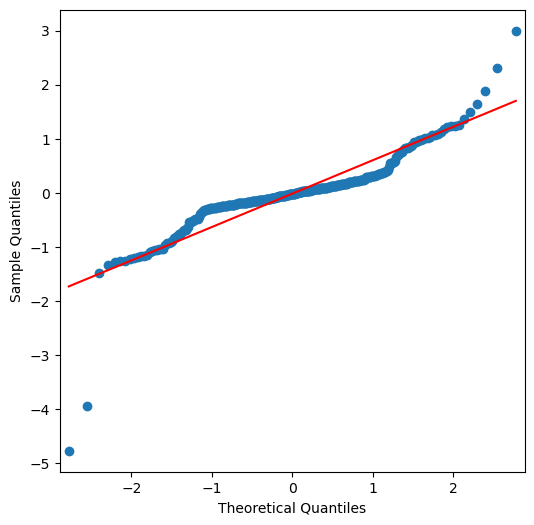

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

residuals = arima_obj_fit.resid[2:]
sm.qqplot(residuals, line='s', ax=ax)
plt.show()

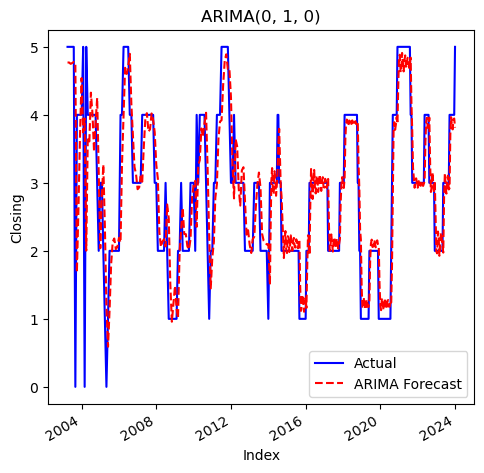

In [44]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

df_ARIMA['Sonora_diffval'].iloc[2:].plot(color='b', linestyle='-', ax=axarr, label='Actual')
df_ARIMA['Sonora_Arima'].iloc[2:].plot(color='r', linestyle='--', ax=axarr, label='ARIMA Forecast')
axarr.set_title('ARIMA(3, 0, 3)')
axarr.set_xlabel('Index')
axarr.set_ylabel('Closing')
axarr.legend()

plt.show()

observamos que nuestro forecast es parecido pero no exactamente igual, es buen resultado ya que si fuera perfecto podria decir que esta overfitting.

#### Out-of-Time Cross validation
To do out-of-time cross-validation, we will create the training and testing dataset by splitting the time series into 2 contiguous segments, 85% and 15% respectively.

We will compare our forecast against the actual values.

In [45]:
Sonora=df_new2["Sonora"]
Sonora

2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2023-10-31    4
2023-11-15    4
2023-11-30    4
2023-12-15    4
2023-12-31    5
Name: Sonora, Length: 370, dtype: int32

In [46]:
p_train1 = 0.85 ### 15% for test data

train1 = Sonora[:int(len(Sonora) * p_train1)]
test1 = Sonora[int(len(Sonora) * p_train1):]
train1

2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2021-06-15    5
2021-06-30    5
2021-07-15    5
2021-07-31    5
2021-08-15    4
Name: Sonora, Length: 314, dtype: int32

In [64]:
len(test1)

56

Train dates : 2003-01-31 00:00:00 --- 2021-08-15 00:00:00  (n=314)
Test dates  : 2021-08-15 00:00:00 --- 2023-12-31 00:00:00  (n=57)


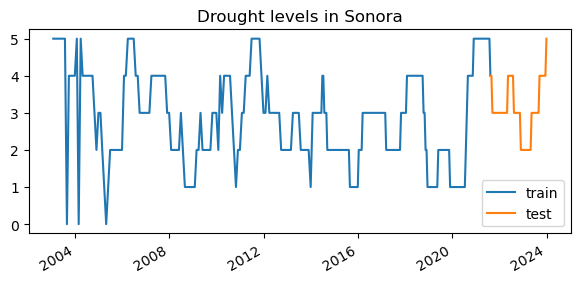

In [47]:

fin_train = '2021-08-15 00:00:00'
print(
    f"Train dates : {Sonora.index.min()} --- {Sonora.loc[:fin_train].index.max()}  "
    f"(n={len(Sonora.loc[:fin_train])})"
)
print(
    f"Test dates  : {Sonora.loc[fin_train:].index.min()} --- {Sonora.loc[:].index.max()}  "
    f"(n={len(Sonora.loc[fin_train:])})"
)
data_train = Sonora.loc[:fin_train]
data_test  = Sonora.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Drought levels in Sonora')
ax.legend();

We will apply the ARIMA model again using only the training data

In [48]:
arima_obj_So = ARIMA(data_train.tolist(), order = (3, 0, 3))

model_So_fit = arima_obj_So.fit()

model_So_fit.summary()

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -310.167
Date:                Fri, 01 Nov 2024   AIC                            636.333
Time:                        00:11:40   BIC                            666.328
Sample:                             0   HQIC                           648.319
                                - 314                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8975      0.355      8.153      0.000       2.201       3.594
ar.L1          0.5187      0.117      4.427      0.000       0.289       0.748
ar.L2         -0.4358      0.097     -4.504      0.000      -0.625      -0.246
ar.L3          0.7211      0.074      9.722      0.000       0.576       0.866
ma.L1          0.0838      0.114      0.733      0.463      -0.140       0.308
ma.L2          0.8288      0.059     13.987      0.000       0.713       0.945
ma.L3         -0.1841      0.061     -3.023      0.003      -0.303      -0.065
sigma2         0.4197      0.023     18.353      0.000       0.375       0.465
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2352.05
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
data_test.index
datdata = pd.Series(data_test.index)

In [54]:
forecast_obj = model_So_fit.get_forecast(steps=57)
forecast_values = forecast_obj.predicted_mean  # Valores puntuales
confidence_intervals = forecast_obj.conf_int(alpha=0.05) 

In [52]:
fc = model_So_fit.forecast(57, alpha=0.05)  
fc

array([4.16074718, 3.8345592 , 3.78444946, 3.86011061, 3.68597947,
       3.52655731, 3.57430803, 3.54298199, 3.39096786, 3.36020511,
       3.38790316, 3.30605898, 3.22935564, 3.24520927, 3.22783997,
       3.15661237, 3.13866914, 3.14787627, 3.10910935, 3.07205096,
       3.0763622 , 3.06679273, 3.03322812, 3.0230978 , 3.02556936,
       3.00706265, 2.98908174, 2.98960231, 2.98436281, 2.96845249,
       2.96285876, 2.96311247, 2.95420886, 2.94544662, 2.9449647 ,
       2.94211274, 2.93452512, 2.93148489, 2.93115791, 2.92684179,
       2.92255332, 2.92197404, 2.92043004, 2.91678927, 2.91515599,
       2.91478202, 2.91267445, 2.91056653, 2.91012194, 2.90929016,
       2.90753247, 2.90666267, 2.90637768, 2.90534144, 2.90430095,
       2.90400733, 2.90356123])

In [68]:
forecast_index = pd.date_range(start=data_train.index[-1], periods=57,freq='2W')

In [69]:
forecast_index

DatetimeIndex(['2021-08-15', '2021-08-29', '2021-09-12', '2021-09-26',
               '2021-10-10', '2021-10-24', '2021-11-07', '2021-11-21',
               '2021-12-05', '2021-12-19', '2022-01-02', '2022-01-16',
               '2022-01-30', '2022-02-13', '2022-02-27', '2022-03-13',
               '2022-03-27', '2022-04-10', '2022-04-24', '2022-05-08',
               '2022-05-22', '2022-06-05', '2022-06-19', '2022-07-03',
               '2022-07-17', '2022-07-31', '2022-08-14', '2022-08-28',
               '2022-09-11', '2022-09-25', '2022-10-09', '2022-10-23',
               '2022-11-06', '2022-11-20', '2022-12-04', '2022-12-18',
               '2023-01-01', '2023-01-15', '2023-01-29', '2023-02-12',
               '2023-02-26', '2023-03-12', '2023-03-26', '2023-04-09',
               '2023-04-23', '2023-05-07', '2023-05-21', '2023-06-04',
               '2023-06-18', '2023-07-02', '2023-07-16', '2023-07-30',
               '2023-08-13', '2023-08-27', '2023-09-10', '2023-09-24',
      

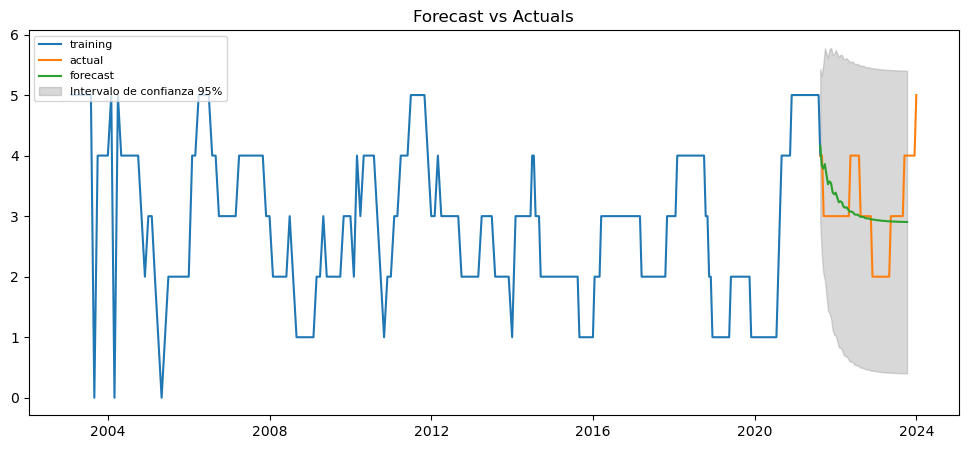

In [70]:
#fc = model_So_fit.forecast(57, alpha=0.05)  # 95% conf
#conf= model_So_fit.forecast(57, alpha=0.05) 
# Make as pandas series
fc_series = pd.Series(forecast_values, index=forecast_index)
#lower_series = pd.Series(confidence_intervals.iloc[:, 0], index=datdata)
#upper_series = pd.Series(confidence_intervals.iloc[:, 1], index=datdata)

forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals[:, 0],
    'Upper CI': confidence_intervals[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='training')
plt.plot(data_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.3, label='Intervalo de confianza 95%')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()